# 1. Классификация изображений по стилям художников


In [237]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torchvision import datasets, transforms, models
from torch import optim, nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

torch.manual_seed(1)


Необходимо загрузить датасет в DataLoader.   Предварительно было решено оставить 2 пайплайна: 

Простой препроцессинг (transform):
1) Преобразовать изображения в размер 128х128 
2) Нормализовать данные в соответствии со средними значениями и среднквадратическими отклонениями ImageNet

Препроцессинг с аугментацией (transform_augmented): 
1) Взять случайный кроп и преобразовать в размер 128х128 
2) Горизонтальное отражение с вероятностью 50%
3) Нормализовать данные в соответствии со средними значениями и среднквадратическими отклонениями ImageNet


In [238]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform_augmented = transforms.Compose([transforms.RandomResizedCrop((128,128),scale=(0.08,1.0)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])])

transform = transforms.Compose([transforms.Resize((128,128)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])])
                             
traindata = datasets.ImageFolder(root= "./images", 
                                 transform = transform_augmented)

valdata =  datasets.ImageFolder(root= "./images", 
                                 transform = transform)


В первую очередь нужно посмотреть какие есть классы и сколькими изображениями они представлены. 

<AxesSubplot:>

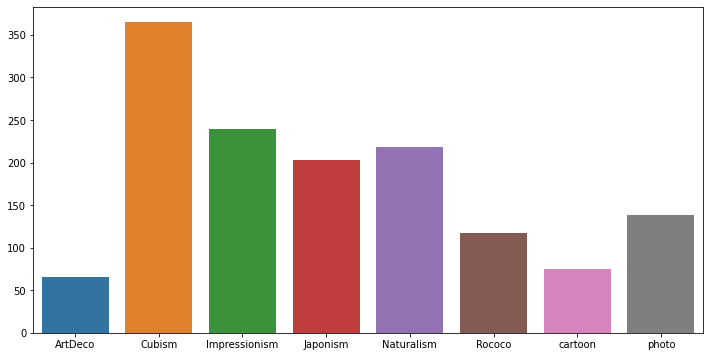

In [239]:
classes = traindata.classes
num_classes = len(traindata.classes)
img_dict = {}
for i in range(num_classes):
    img_dict[classes[i]] = 0

for i in range(len(traindata)):
    img, label = traindata[i]
    img_dict[classes[label]] += 1

plt.figure(figsize=(12,6))
sns.barplot(x=list(img_dict.keys()),y=list(img_dict.values()))


Как можно заметить, данные дисбалансы, арт-деко и мультфильмы слабо представлены, кубизм избыточно представлен. 
Есть различные решения, к которым можно прибегнуть, но в данном задании будет достаточно использовать различные веса для каждого класса в соответствии с их представленностью в данных. Для этого используем метод compute_class_weight из sklearn. 

In [240]:
from sklearn.utils.class_weight import compute_class_weight

class_weights=compute_class_weight('balanced',classes=np.unique(traindata.targets),y=traindata.targets)
class_weights=torch.tensor(class_weights,dtype=torch.float).to(device)


Для равномерного распределения данных в тренировочной и валидационной выборках необходимо также использовать stratify в train_test_split. 

In [241]:
targets = traindata.targets
train_idx, test_idx= train_test_split(
                        np.arange(len(targets)),
                        test_size=0.2,
                        shuffle=True,
                        stratify=targets,
                        random_state=1)

Выбрав индексы для тренировочной и валидационной выборок, можно создать соответствующие DataLoader'ы.

In [242]:
batch_size = 32
train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
valid_sampler = torch.utils.data.SubsetRandomSampler(test_idx)

train_loader = torch.utils.data.DataLoader(traindata, batch_size=batch_size, sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(valdata, batch_size=batch_size, sampler=valid_sampler)

В рамках задания изначально хотелось проверить исходные данные на классических моделях, используемых в задачах классификации изображений. Выбор осуществлялся исходя из набора возможных моделей ```torchvision.models```. Основным критерием была совокупность размера модели и результаты accuracy с бенчмарков в документации PyTorch. Из наиболее подходящих можно выделить **Resnet18** и **EfficientNet B0**. **Resnet18** выбран так как из-за простоты архитектуры с ней значительно проще и быстрее проводить эксперименты в контексте текущего задания.


*Забегая вперед скажу что в процессе выполнения задачи была реализована модель Resnet18 на которой предпринимались попытки избежать переобучения (добавление Dropout'ов, регуляризация, изменение/удаление слоев в архитектуре для упрощения модели). В среднем показатели измеряемых метрик стали лучше после большинства экспериментов, но всё же отставали от предобученной модели. В приложении оставлю реализацию модели Resnet18. Если исходить из всех проведенных экспериментов сложилось ощущение малой репрезентативности (или сложности обобщения данных) классов в данных: Validation loss или прыгал волнами или не опускался определенного значения, в случае переобучения Validation loss иногда поднимался.*

Функцией ошибки была выбрана **Cross Entropy Loss**, как весьма часто используемая функция ошибки при многоклассовой классификации, демонстрируя разницу между распределением вероятности истины и предсказания модели для всех классов. Для оценки качества модели в течение времени отслеживаются **Train loss** и **Validation loss**, помимо этого для оценки работы классификатора используется примитивный **Accuracy**, который скорее нужен для мониторинга состояния и подсчета корректных классификаций. 

Финальная модель выбирается на основе минимального значения **Validation loss**, чтобы не получить переобученную на тренировочных данных модель. Помимо этого финальная модель оценивается по метрикам **Precision**, **Recall** и **F1-Score**. Дополнительно строится матрица неточностей, чтобы сравнить истину и предсказанные результаты для каждого класса.

In [243]:
model =  models.resnet18(pretrained=True)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Основной идеей было добиться неплохой точности модели при классификации (хотя бы 60%+), поэтому чтобы минимизировать возможность переобучения, большая часть слоев были заморожены кроме предпоследнего (layer4: состоит из 5 Conv2d слоев) и последнего. 

In [244]:
for param in model.parameters():
    param.requires_grad_(False)
for param in model.layer4.parameters():
    param.requires_grad_(True)

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs,num_classes)
model.to(device)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Для оптимайзера был выбран Adam, однако в некоторых экспериментах SGD показал лучшую сходимость, но ожидаемую меньшую стабильность. В Cross Entropy необходимо также обязательно передать аргумент с весами для классов.

In [245]:
optimizer = optim.Adam(model.parameters(), lr =1e-4)
criterion = nn.CrossEntropyLoss(weight=class_weights,reduction='mean')
epochs = 30

In [246]:
save = float('inf')

run_stats = {'train_loss':[], 'val_loss':[],'train_accuracy':[],'val_accuracy':[]}
trainL= []
testL = []
for e in range(epochs):
    
    train_loss = 0
    train_accuracy = 0
    model.train()
    
    trainloaderSize = 0
    testloaderSize = 0
    for images, labels in train_loader:
        
        trainloaderSize += 1
        images, labels = images.to(device), labels.to(device)
        output = model(images).to(device)
        optimizer.zero_grad()

        loss = criterion(output, labels)
        train_loss += loss.item() * images.shape[0]

        loss.backward()
        optimizer.step()
        
        
        prob = torch.exp(output)
        class_val, class_num = prob.topk(1, dim = 1)
        equal = labels == class_num.view(labels.shape)
        train_accuracy += torch.mean(equal.type(torch.FloatTensor)).item()
    
    
    with torch.no_grad():
        
        model.eval()
        val_loss = 0
        val_accuracy = 0
        y_pred =[]
        y = []
        
        for images, labels in valid_loader:

            
            testloaderSize += 1
            images, labels = images.to(device), labels.to(device)
            output = model(images).to(device)
            loss = criterion(output, labels)
            val_loss += loss.item() * images.shape[0]
            
            prob = torch.exp(output)
            class_val, class_num = prob.topk(1, dim = 1)
            equal = labels == class_num.view(labels.shape)

            y.extend(labels.tolist())
            y_pred.extend(class_num.view(labels.shape).tolist())
            val_accuracy += torch.mean(equal.type(torch.FloatTensor)).item()
        
        train_accuracy = train_accuracy / trainloaderSize
        val_accuracy = val_accuracy / testloaderSize
        val_loss = val_loss/ (testloaderSize * batch_size)
        train_loss = train_loss/ (trainloaderSize * batch_size)

        
        print("Epoch-",e ,"    Validation Loss-",val_loss, 
              "    Train Loss-", train_loss,"Train Accuracy", train_accuracy,"Validation Accuracy-",val_accuracy, "\n" )
        
        run_stats["train_loss"].append(train_loss)
        run_stats["val_loss"].append(val_loss)
        run_stats["train_accuracy"].append(train_accuracy)
        run_stats["val_accuracy"].append(val_accuracy)
        if val_loss < save:
            
            report = classification_report(y, y_pred, target_names=traindata.classes)
            cf_matrix = confusion_matrix(y, y_pred)
            saved_epoch = e


            print("Model saving")
            print("Test Loss -", val_loss, " is less than Previous Loss -", save,"\n" )
            torch.save(model.state_dict(), 'model.pth')
            save = val_loss


Epoch- 0     Validation Loss- 1.1833388780554135     Train Loss- 1.585151750076976 Train Accuracy 0.44439338313208687 Validation Accuracy- 0.6133860150973002 

Model saving
Test Loss - 1.1833388780554135  is less than Previous Loss - inf 

Epoch- 1     Validation Loss- 0.9645235199067328     Train Loss- 0.9310075829012526 Train Accuracy 0.6846405234601762 Validation Accuracy- 0.6870210700564914 

Model saving
Test Loss - 0.9645235199067328  is less than Previous Loss - 1.1833388780554135 

Epoch- 2     Validation Loss- 0.9083398408773873     Train Loss- 0.7159107723790739 Train Accuracy 0.7597528596719106 Validation Accuracy- 0.7398227983050876 

Model saving
Test Loss - 0.9083398408773873  is less than Previous Loss - 0.9645235199067328 

Epoch- 3     Validation Loss- 0.8788495982686678     Train Loss- 0.5996492495760322 Train Accuracy 0.7865093954735332 Validation Accuracy- 0.7339559396107992 

Model saving
Test Loss - 0.8788495982686678  is less than Previous Loss - 0.90833984087738

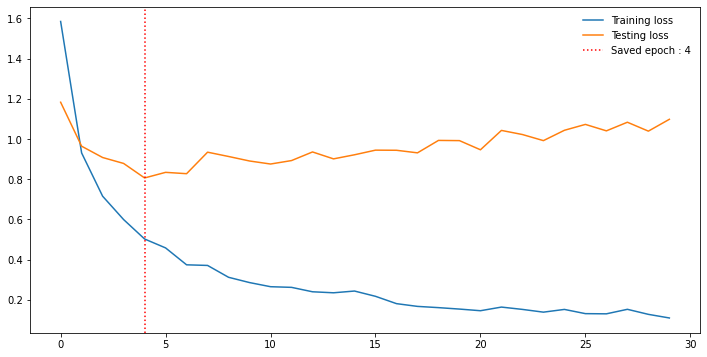

In [252]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot(run_stats["train_loss"], label='Training loss')
plt.plot(run_stats["val_loss"], label='Testing loss')
plt.axvline(saved_epoch,ls=":",label=f"Saved epoch : {saved_epoch}",color="red")
plt.legend(frameon=False)




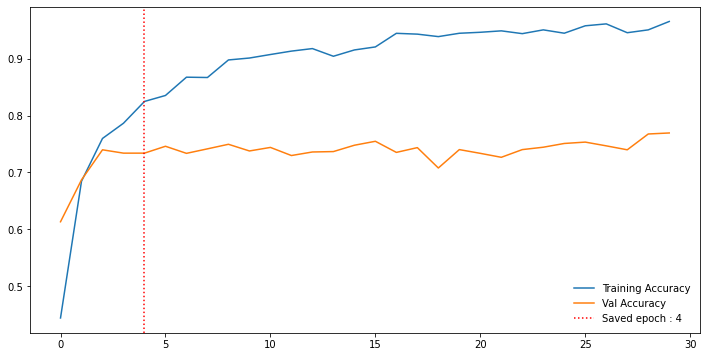

In [253]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot(run_stats["train_accuracy"], label='Training Accuracy')
plt.plot(run_stats["val_accuracy"], label='Val Accuracy')
plt.axvline(saved_epoch,ls=":",label=f"Saved epoch : {saved_epoch}",color="red")

plt.legend(frameon=False)



               precision    recall  f1-score   support

      ArtDeco       0.56      0.38      0.45        13
       Cubism       0.94      0.82      0.88        73
Impressionism       0.67      0.58      0.62        48
     Japonism       0.65      0.73      0.69        41
   Naturalism       0.83      0.68      0.75        44
       Rococo       0.56      0.87      0.68        23
      cartoon       0.55      0.73      0.63        15
        photo       0.78      0.89      0.83        28

     accuracy                           0.73       285
    macro avg       0.69      0.71      0.69       285
 weighted avg       0.75      0.73      0.73       285



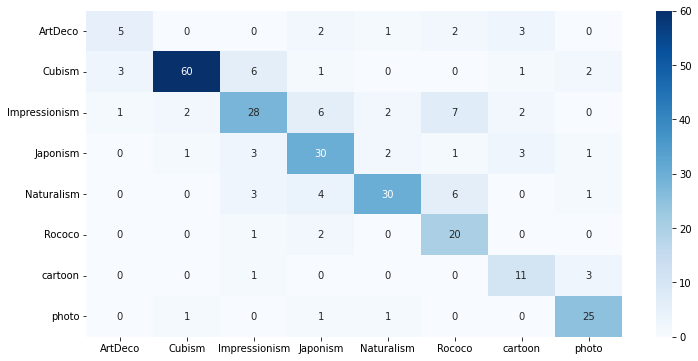

In [366]:
print(report)
plt.figure(figsize=(12,6))
sns.heatmap(cf_matrix, annot=True,xticklabels=traindata.classes,yticklabels=traindata.classes,cmap='Blues')
plt.show()

In [274]:
def getCAM(feature_conv, weight_fc, class_idx):
    _, nc, h, w = feature_conv.shape
    cam = weight_fc[class_idx].dot(feature_conv.reshape((nc, h*w)))
    cam = cam.reshape(h, w)
    cam = cam - np.min(cam)
    cam_img = cam / np.max(cam)
    return [cam_img]

class SaveFeatures():
    features=None
    def __init__(self, m): 
        self.hook = m.register_forward_hook(self.hook_fn)

    def hook_fn(self, module, input, output): 
        self.features = ((output.cpu()).data).numpy()
    def remove(self): 
        self.hook.remove()

In [275]:
transform_CAM = transforms.Compose([transforms.Resize((128,128)),
        transforms.ToTensor()])
normalize_resnet = transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])

CAM_data =  datasets.ImageFolder(root= "./images",transform=transform_CAM) 
CAM_loader = torch.utils.data.DataLoader(CAM_data, batch_size=1, sampler=valid_sampler)

model = models.resnet18()
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs,8)
model.to(device)
model.load_state_dict(torch.load("model.pth"))
model.eval()

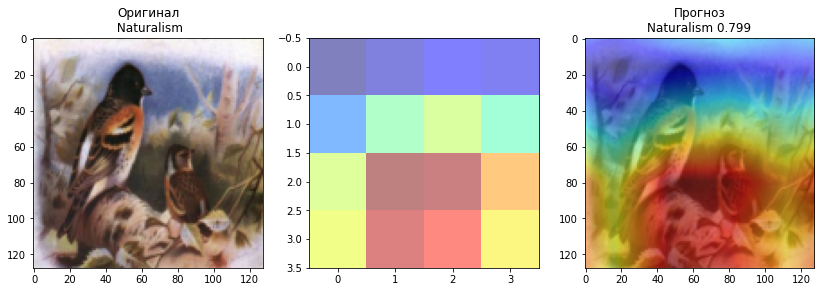

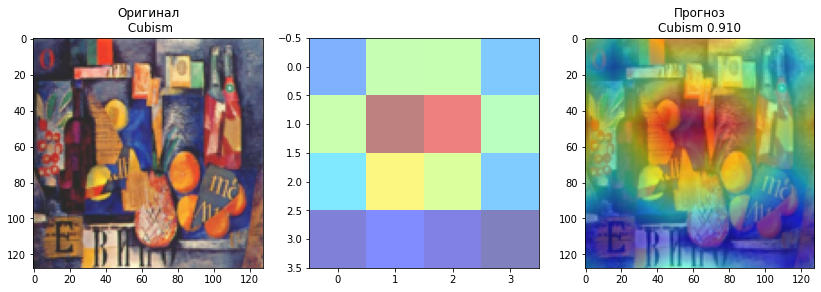

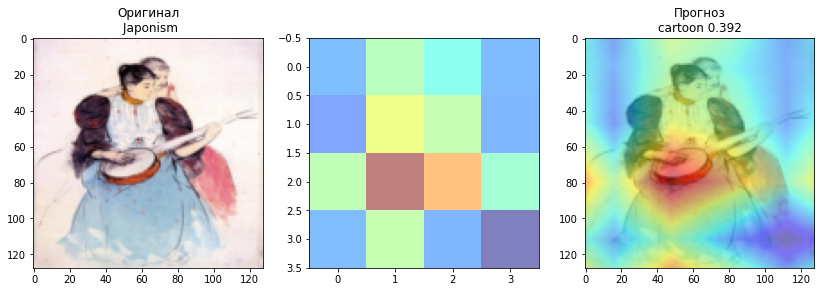

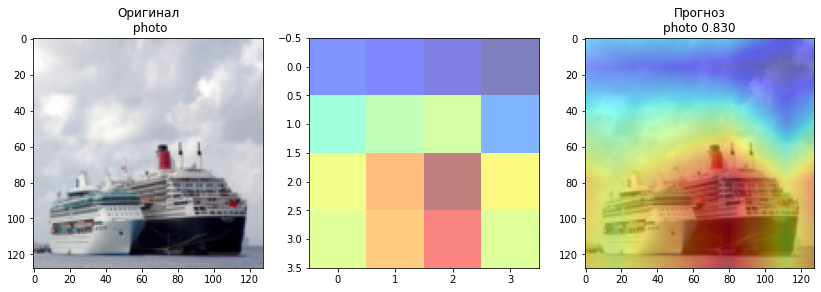

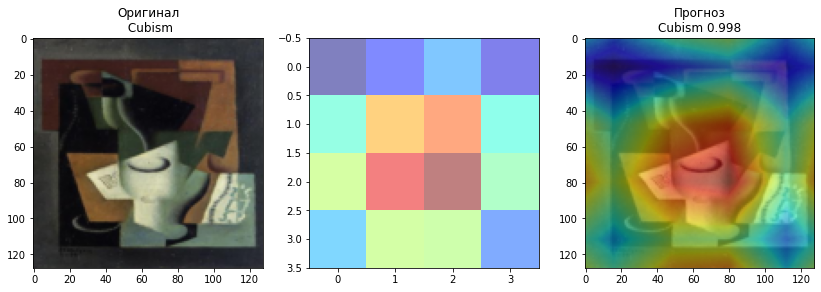

In [369]:
rows = 1
columns = 3
num_of_samples = 5
from torch.autograd import Variable
import skimage.transform

for i in range(num_of_samples):
    image = next(iter(CAM_loader))
    fig = plt.figure(figsize=(14, 7))
    fig.add_subplot(rows, columns, 1)
    original_class = CAM_data.classes[image[1].item()]
    plt.title(f"Оригинал\n {original_class}")
    temp = image[0].squeeze(0)
    plt.imshow(np.transpose(image[0].squeeze(0),(1,2,0)))

    display_transform = transforms.Compose([
    transforms.Resize((128,128))])
    tensor = normalize_resnet(image[0])
    prediction_var = Variable(tensor.cuda(), requires_grad=True)

    final_layer = model._modules.get('layer4')
    activated_features = SaveFeatures(final_layer)
    prediction = model(prediction_var)
    pred_probabilities = F.softmax(prediction,dim=1).data.squeeze()
    activated_features.remove()

    weight_softmax_params = list(model._modules.get('fc').parameters())
    weight_softmax = np.squeeze(weight_softmax_params[0].cpu().data.numpy())

    class_probab,class_idx = torch.topk(pred_probabilities,1)[0].item(),torch.topk(pred_probabilities,1)[1].item()
    predicted_class = CAM_data.classes[class_idx]
    overlay = getCAM(activated_features.features, weight_softmax, class_idx )

    fig.add_subplot(rows, columns, 2)
    plt.imshow(overlay[0], alpha=0.5, cmap='jet')
    fig.add_subplot(rows, columns, 3)
    plt.title(f"Прогноз\n{predicted_class} {class_probab:.3f}")
    plt.imshow(np.transpose(image[0].squeeze(0),(1,2,0)))
    plt.imshow(skimage.transform.resize(overlay[0],(128,128)), alpha=0.5, cmap='jet')
    plt.show()

# 2 clustering


In [370]:
class ImageFolderWithPaths(datasets.ImageFolder):
    
    def __getitem__(self, index):
        sample,target = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]

        return sample,target,path


class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x


In [371]:

model.fc = Identity()
model.to(device)


traindata = ImageFolderWithPaths(root= "./images", 
                                 transform = transform)
targets = traindata.targets

In [421]:

train_loader = torch.utils.data.DataLoader(traindata, batch_size=batch_size)

feature_vector =[]
classes = []
paths = []

with torch.no_grad():
        
        model.eval()
        test_loss = 0
        accuracy = 0
        
        for images, labels,img_paths in train_loader:
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            prob = torch.exp(output)

            if len(feature_vector) ==0:
                feature_vector = output.cpu().numpy()
                paths = list(img_paths)
            else:
                feature_vector = np.append(feature_vector,output.cpu().numpy(),axis=0)
                paths.extend(img_paths)

            class_val, class_num = prob.topk(1, dim = 1)
            equal = labels == class_num.view(labels.shape)
            classes.extend(labels.tolist())
                    

        var1       var2  target  \
0 -25.834343 -14.528217       0   
1   8.811646  20.887468       0   
2  22.692984  15.317280       0   
3  27.558706  16.870155       0   
4  12.081430  12.120852       0   

                                            img_path    style  
0  ./images\ArtDeco\aleksandra-ekster_woman-with-...  ArtDeco  
1  ./images\ArtDeco\bernardo-marques_antonio-ferr...  ArtDeco  
2  ./images\ArtDeco\bernardo-marques_civiliza-o-n...  ArtDeco  
3   ./images\ArtDeco\bernardo-marques_civiliza-o.jpg  ArtDeco  
4  ./images\ArtDeco\bernardo-marques_fernanda-de-...  ArtDeco  


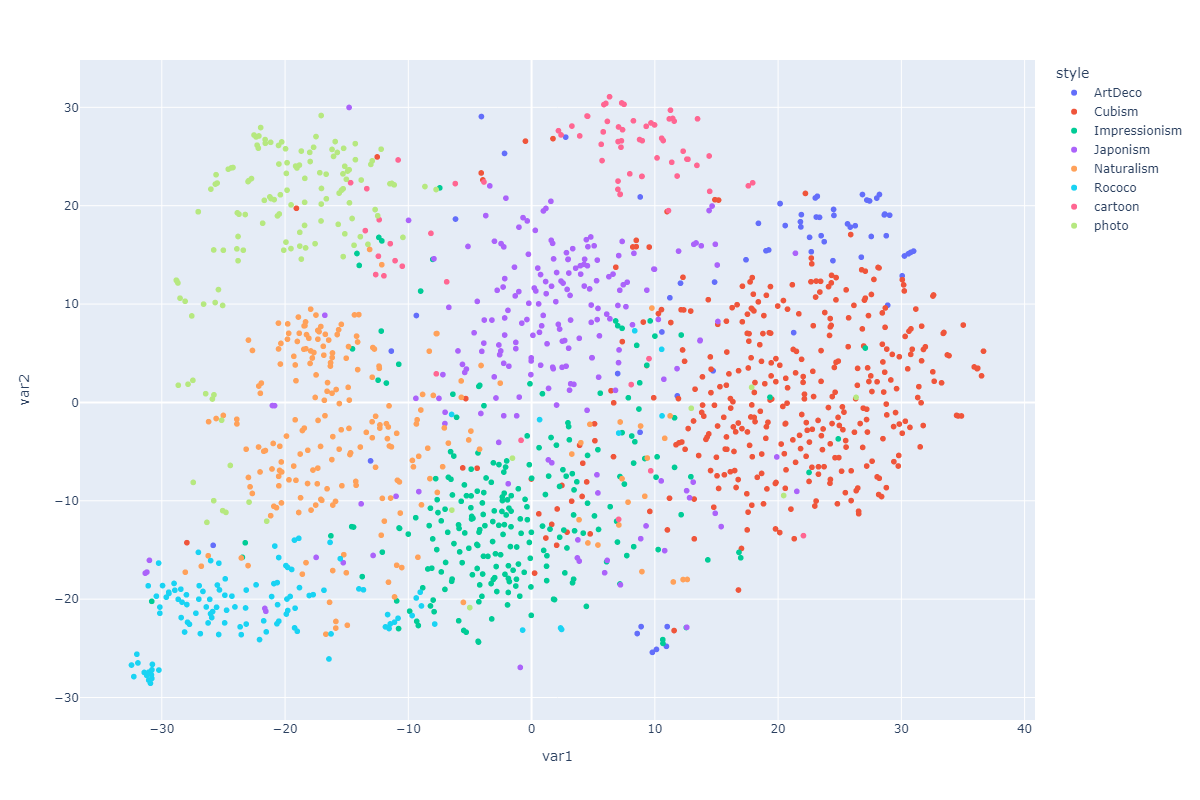

In [627]:

from sklearn.decomposition import PCA
import seaborn as sns
import plotly.express as px
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import plotly.graph_objects as go
from PIL import Image


pca = TSNE(n_components=2,learning_rate='auto',init='random',random_state=1)
temp = np.copy(feature_vector)


scaler = StandardScaler()
temp =scaler.fit_transform(temp)

plotik = pca.fit_transform(temp)

styles = [traindata.classes[x] for x in classes]


df = pd.DataFrame(plotik, columns=["var1","var2"])
df['target'] = classes
df['img_path'] = paths
df['style'] = styles
print(df.head())
fig = px.scatter(df, x="var1", y="var2", color="style", hover_data=['img_path'])
fig.update_layout(
    autosize=False,
    width=1200,
    height=800)
fig


# данные 2 строки только для вывода картинки на гитхабе, в обычном ноутбуке вызовется интерактивный plotly, где можно выбрать точку и увидеть путь файла 
# (было интересно посмотреть какие именно картинки попали в другие кластеры)
image = Image.open('cluster1.png')
image

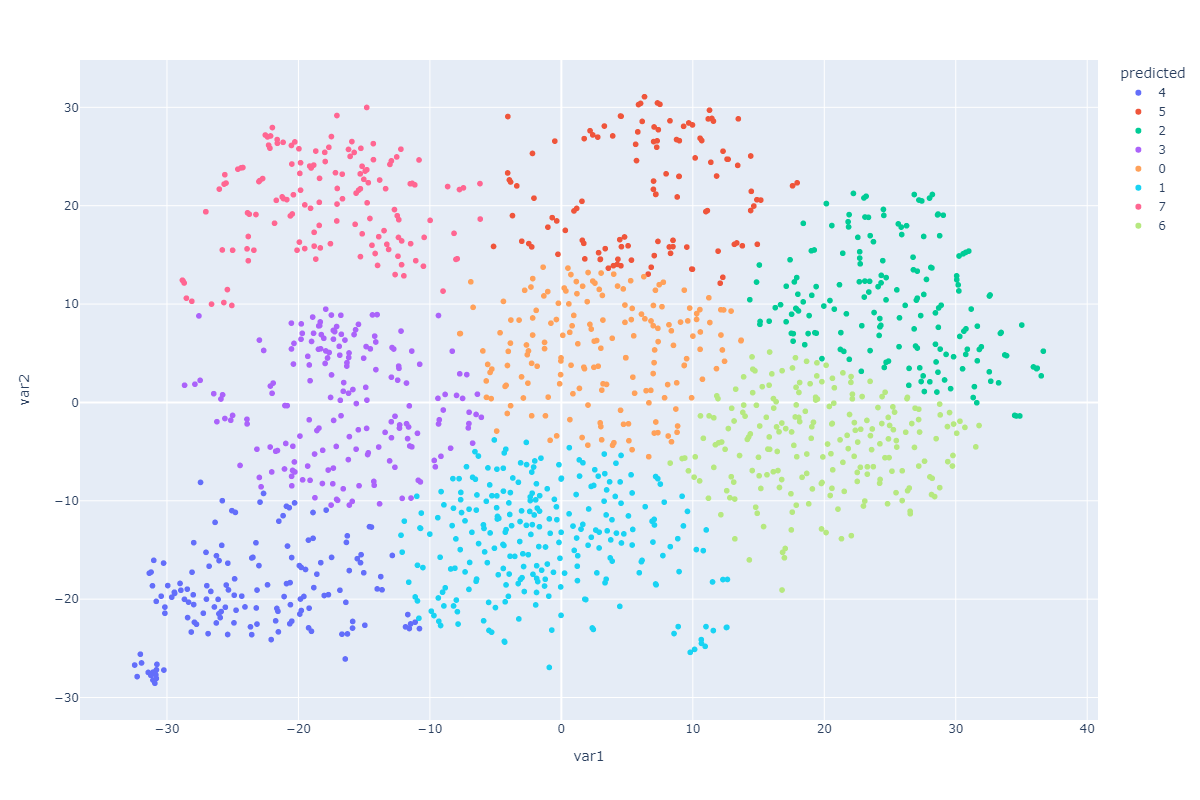

In [639]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

temp = df[['var1','var2',]].to_numpy()
kmeans = KMeans(n_clusters=8).fit_predict(temp)

df['predicted'] = kmeans
df['predicted'] = df['predicted'].astype(str)
fig = px.scatter(df, x="var1", y="var2", color="predicted", hover_data=['img_path'])
fig.update_layout(
    autosize=False,
    width=1200,
    height=800)
fig
# df

# данные 2 строки только для вывода картинки на гитхабе, в обычном ноутбуке вызовется интерактивный plotly, где можно выбрать точку и увидеть путь файла 
# (было интересно посмотреть какие именно картинки попали в другие кластеры)
image = Image.open('cluster2.png')
image


In [637]:
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
from math import isnan


def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) # heuristic from article [1]
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print (ujd, wjd)
        H = 0
 
    return H

In [638]:
from sklearn.metrics.cluster import adjusted_rand_score

print('Hopkins=',hopkins(df[['var1','var2']]))
print("ARI=",adjusted_rand_score(kmeans,df['target']))
print("Silhoutette score=",silhouette_score(temp,kmeans,metric='euclidean'))


Hopkins= 0.7991273009431744
ARI= 0.4269719554908821
Silhoutette score= 0.41097203


# 3 Xgboost
